In [127]:
import os
cwd = os.getcwd().replace("\\", "/")
print(cwd)

c:/Users/Timothe/Documents/eth4/cil/github/CIL/models/segformer


In [128]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import requests
import wandb
from sklearn.metrics import f1_score
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from glob import glob
from albumentations import (
    HorizontalFlip,
    VerticalFlip,
    RandomRotate90,
    ShiftScaleRotate,
    RandomBrightnessContrast,
    CLAHE,
    HueSaturationValue,
    GaussNoise,
    GridDistortion,
    Compose,
    RandomCrop
)
import cv2


BATCH_SIZE = 1

kaggle = True if cwd == "/kaggle/working" else False
data_path = "/kaggle/input/" if kaggle else cwd + "/../../data/"

# if kaggle:
#     main_path = data_path+"ethz-cil-road-segmentation-2023/"
#     pretrain_path = data_path+"massachusetts-roads-dataset/"
# else:
#     main_path = data_path+"official_roads/"
#     pretrain_path = data_path+"massachusetts_roads/"

# main_x_path = main_path + "training/images/"
# main_y_path =  main_path + "training/groundtruth/"

# pretrain_x_path =  pretrain_path + "tiff/train/"
# pretrain_y_path =  pretrain_path + "tiff/train_labels/"

#takes path of x and returns x and y as images
def get_label(x_path):
    x_path = x_path.replace("\\", "/")
    if x_path.__contains__("massachusetts"):
        y_path = x_path.replace("tiff/train/", "tiff/train_labels/").replace(".tiff", ".tif")

    if x_path.__contains__("ethz"):
        y_path = x_path.replace("images/", "groundtruth/")

    if x_path.__contains__("deepglobe"):
        y_path = x_path.replace("sat.jpg", "mask.png")

    return Image.open(x_path), Image.open(y_path)


def save(model, name):
    torch.save(model.state_dict(), ("/kaggle/working/" if kaggle else "") + name + ".pth")

def load(model, name):
    model.load_state_dict(torch.load(("/kaggle/input/" if kaggle else "") + name + ".pth"))
    model.eval()
    

In [129]:
# Load the model and setup the classifier head for binary classification
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640")
model.decode_head.classifier = nn.Conv2d(768, 1, kernel_size=(1, 1), stride=(1, 1))
model = model.cuda()

# Instantiate the feature extractor
feature_extractor:SegformerImageProcessor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b5-finetuned-ade-640-640", size=800)

# Do a forward pass with random data to initialize the model
# x = torch.randn(1, 3, 800, 800).cuda()
# y = model(x).logits
# print(y.shape)


print("model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

model parameters: 84594113


c:\ProgramData\Anaconda3\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:99: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [130]:
def get_geometric_transforms():
    geometric_transforms = [
        RandomCrop(height=256, width=256, p=1),
        HorizontalFlip(p=0.5),
        VerticalFlip(p=0.5),
        RandomRotate90(p=0.5),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        GridDistortion(p=0.5)
    ]
    return Compose(geometric_transforms, additional_targets={'mask':'image'})

def get_photometric_transforms():
    photometric_transforms = [
        RandomBrightnessContrast(p=0.5),
        CLAHE(p=0.5),
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
        GaussNoise(p=0.5)
    ]
    return Compose(photometric_transforms)


class CustomDataset(Dataset):
    def __init__(self, image_files, geometric_transform=None, photometric_transform=None):
        self.image_files = image_files
        self.geometric_transform = geometric_transform
        self.photometric_transform = photometric_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        x_orig, y_orig = get_label(self.image_files[idx])

        x_orig:Image = x_orig.convert("RGB")
        y_orig:Image = y_orig.convert("RGB")

        if x_orig.size[0] > 400 or x_orig.size[1] > 400:
            x_orig = x_orig.resize((400, 400))
        if y_orig.size[0] > 400 or y_orig.size[1] > 400:
            y_orig = y_orig.resize((400, 400))
        
        x_orig_np = np.array(x_orig, dtype=np.uint8)
        y_orig_np = np.array(y_orig, dtype=np.uint8)

        # Apply geometric transforms
        x_augmented, y_augmented = x_orig_np.copy(), y_orig_np.copy()
        if self.geometric_transform:
            augmented = self.geometric_transform(image=x_augmented.copy(), mask=y_augmented.copy())
            x_augmented, y_augmented = augmented['image'], augmented['mask']

        # Apply photometric transforms
        if self.photometric_transform:
            augmented = self.photometric_transform(image=x_augmented.copy())
            x_augmented = augmented['image']

        x = feature_extractor(images=Image.fromarray(x_augmented), return_tensors="pt").pixel_values.squeeze(0).cuda()
        y = torch.tensor(y_augmented[:, :, 0], dtype=torch.float32).unsqueeze(0).cuda()

        # Convert the images to float32
        x_orig_np = x_orig_np.astype(np.float32) / 255
        y_orig_np = y_orig_np.astype(np.float32) / 255
        x_augmented = x_augmented.astype(np.float32) / 255
        y_augmented = y_augmented.astype(np.float32) / 255

        return x, y, self.image_files[idx], x_orig_np, y_orig_np, x_augmented, y_augmented



geometric_transform = get_geometric_transforms()
photometric_transform = get_photometric_transforms()

In [131]:
massachusetts_dataset = CustomDataset(glob(data_path + "massachusetts-roads-dataset/tiff/train/*.tiff"), geometric_transform=geometric_transform, photometric_transform=photometric_transform)
massachusetts_loader = DataLoader(massachusetts_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [132]:
deepglobe_dataset = CustomDataset(glob(data_path + "deepglobe-road-extraction-dataset/train/*.jpg"), geometric_transform=geometric_transform, photometric_transform=photometric_transform)
deepglobe_loader = DataLoader(deepglobe_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [133]:
main_dataset = CustomDataset(glob(data_path + "ethz-cil-road-segmentation-2023/training/images/*.png"), geometric_transform=geometric_transform, photometric_transform=photometric_transform)

# Split the dataset
val_size = int(len(main_dataset) * 0.2)
train_size = len(main_dataset) - val_size
torch.manual_seed(0)
train_dataset, val_dataset = random_split(main_dataset, [train_size, val_size])


train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [134]:
def visualize_sample(model, loader):
    with torch.no_grad():
        rows = 2
        fig, ax = plt.subplots(rows, 5, figsize=(20, 30))
        for i, (x, y, name, x_orig, y_orig, x_augmented, y_augmented) in enumerate(loader):
            x = x[0]
            y = y[0]
            name = name[0]
            x_orig = x_orig[0]
            y_orig = y_orig[0]
            x_augmented = x_augmented[0]
            y_augmented = y_augmented[0]

            # print(name)

            # print(pred.shape)
            # print(y.shape)
            # print(x.shape)

            pred = model(x.unsqueeze(0)).logits.squeeze(0)
            # print(pred.shape)

            pred = F.sigmoid(pred).permute(1, 2, 0).cpu().numpy()
            y = y.permute(1, 2, 0).cpu().numpy()
            x = x.permute(1, 2, 0).cpu().numpy()

            # print(pred.shape)
            # print(y.shape)
            # print(x.shape)

            # print(pred)
            # print(y)
            # print(x)

            ax[i][0].imshow(x_orig)
            ax[i][1].imshow(y_orig)
            ax[i][2].imshow(x_augmented)
            ax[i][3].imshow(y_augmented)
            ax[i][4].imshow(pred, cmap='gray')
            

            if i == rows - 1:
                break


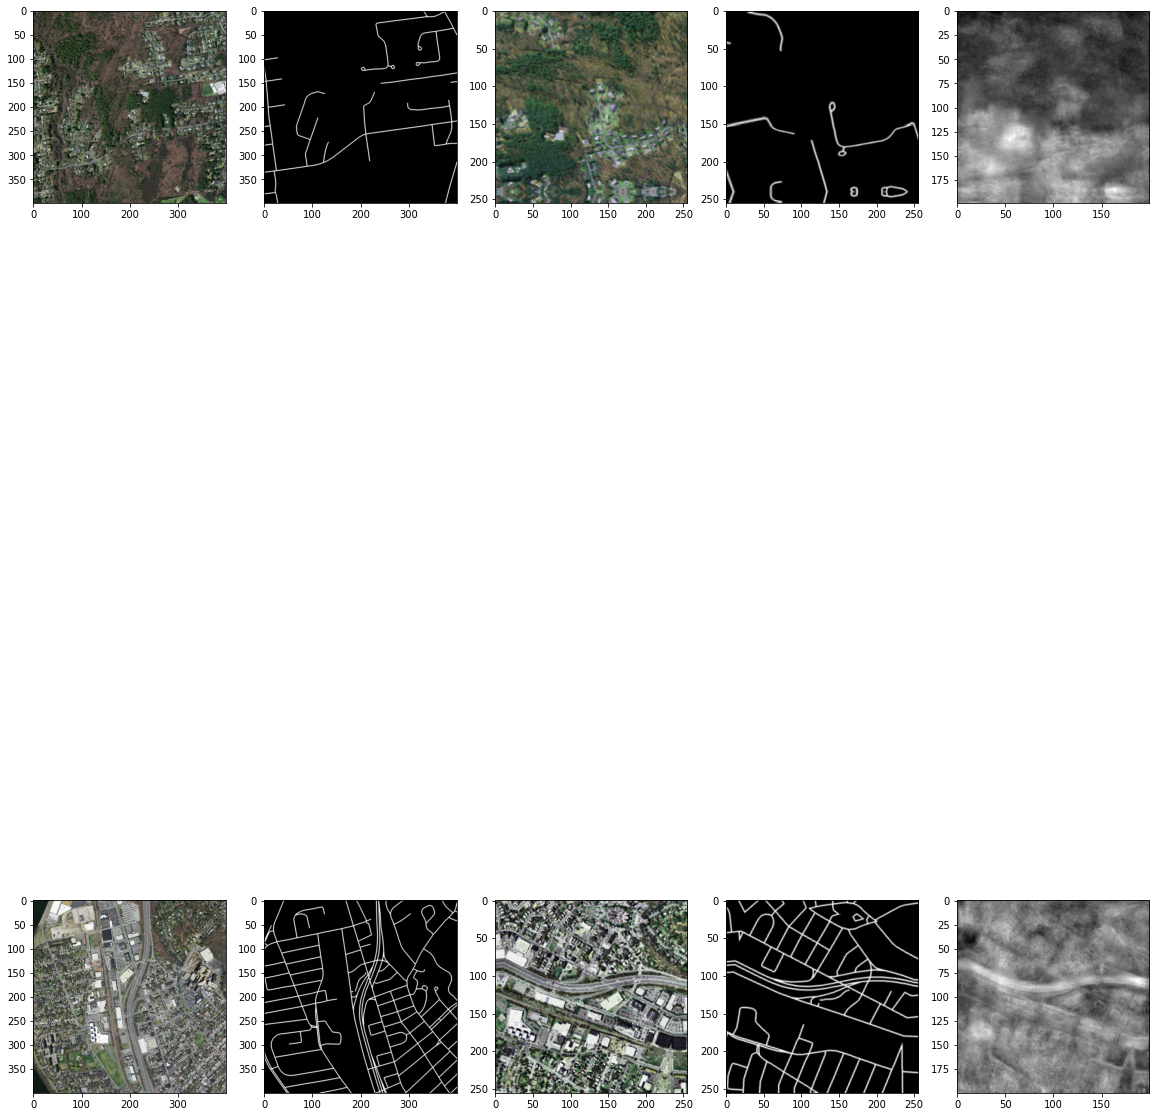

In [135]:
visualize_sample(model, massachusetts_loader)

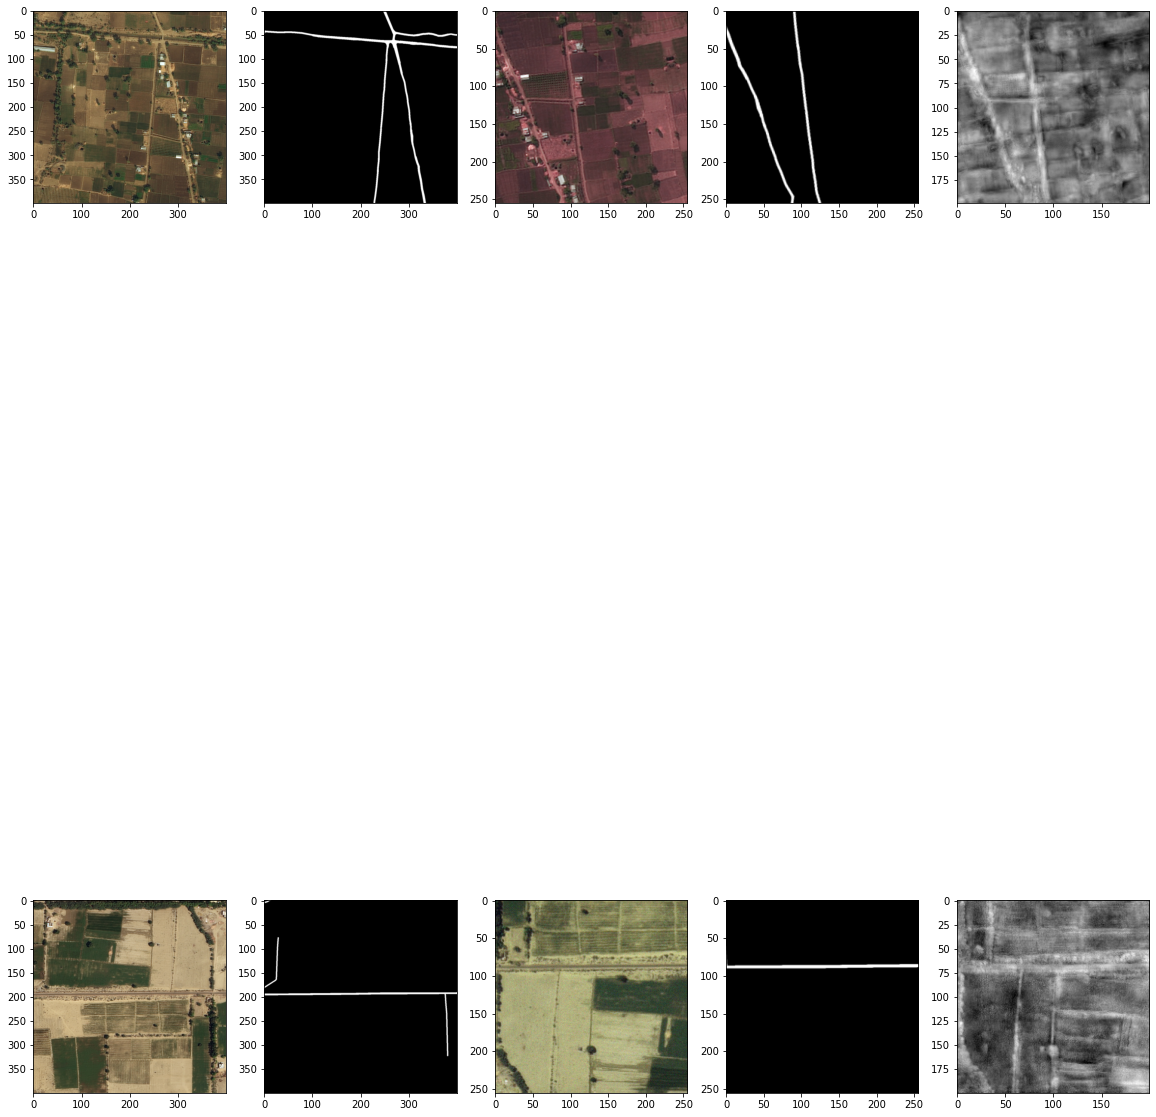

In [136]:
visualize_sample(model, deepglobe_loader)

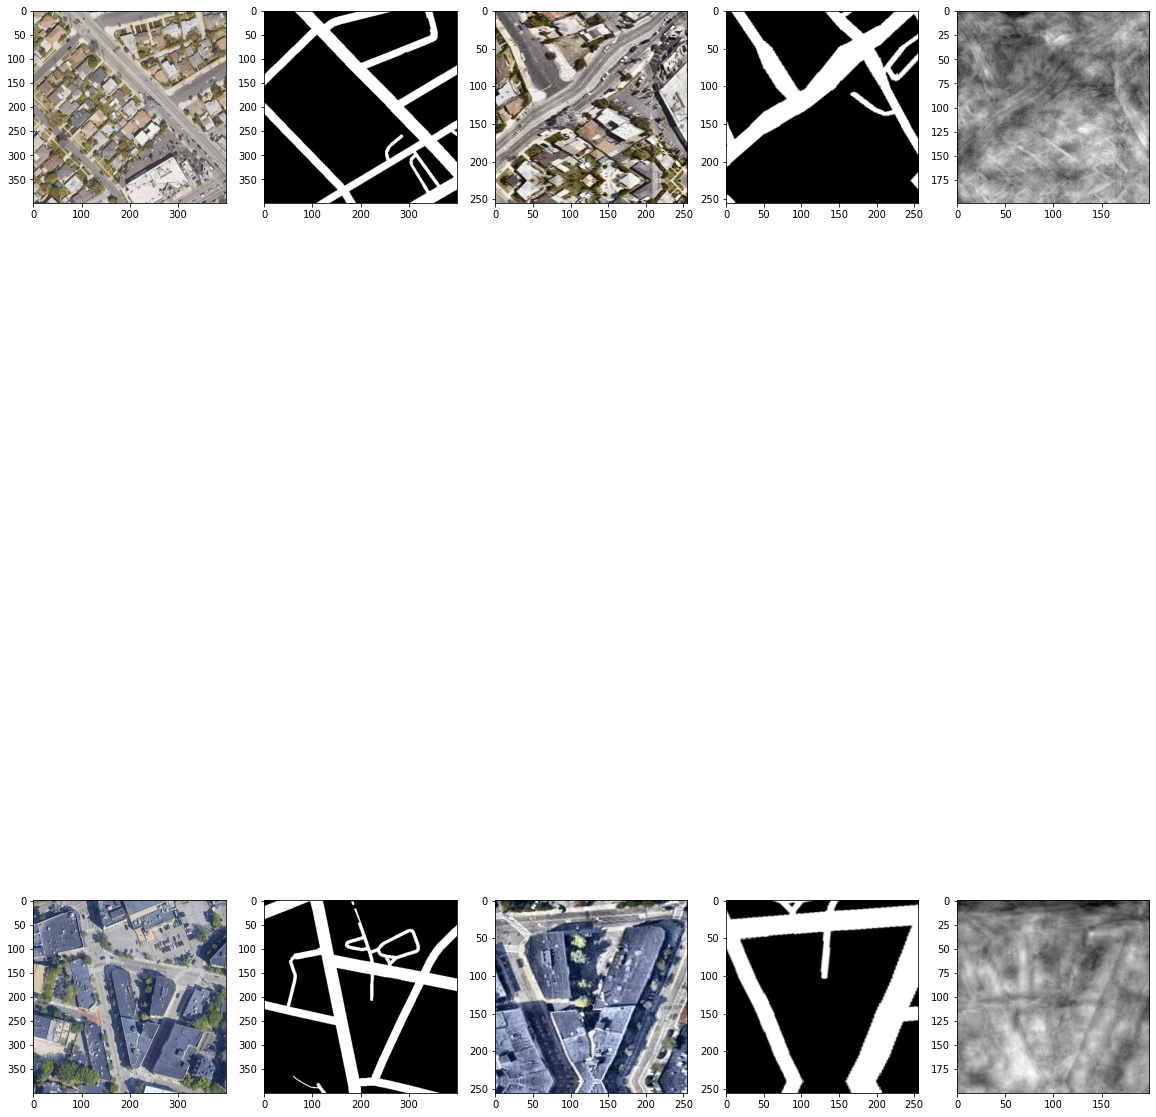

In [137]:
visualize_sample(model, val_loader)

In [10]:
# Set up training
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [11]:
use_wandb = False

def train(model, dataset, optimizer):
    model.train()
    total_loss = 0
    for x, y, _a, _b, _c in tqdm(dataset):
        x, y = x.cuda(), y.cuda()     
        optimizer.zero_grad()
        y_pred = model(x).logits
        y_pred = torch.repeat_interleave(torch.repeat_interleave(y_pred, 2, dim=2), 2, dim=3)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print("Training Loss:", total_loss / len(dataset))
    if use_wandb: wandb.log({"Train Loss": total_loss / len(dataset)})

In [19]:
def validate(model, dataset):
    model.eval()
    y_preds = np.array([], dtype=np.float32)
    y_gt = np.array([], dtype=np.float32)
    with torch.no_grad():
        for x, y, _a, _b, _c in dataset:
            x, y = x.cuda(), y.cuda()  
            # print(x.shape , y.shape)
            y_pred = model(x).logits
            y_pred = torch.sigmoid(y_pred)

            # apply pooling to reduce the prediction from 200x200 to 25x25
            y_pred = F.avg_pool2d(y_pred, 8, stride=8)
            # apply pooling to reduce the label from 400x400 to 25x25
            y = F.avg_pool2d(y, 16, stride=16)

            y_preds = np.concatenate((y_preds, y_pred.cpu().numpy().flatten()))
            y_gt = np.concatenate((y_gt, y.cpu().numpy().flatten()))
            
            
    y_preds = np.array(y_preds)
    y_gt = np.array(y_gt)
    for tresh in np.arange(0.05,0.5,0.05):        
        score = f1_score(y_gt>0.25, y_preds > tresh)
        print("Validation F1 Score for tresh",tresh,":", score)
        if use_wandb: wandb.log("Validation F1 Score for tresh "+str(tresh) +": " + str(score))


In [ ]:

# Initialize wandb
if use_wandb: wandb.init(project="CIL 2023", entity="tlaborie")
if use_wandb: wandb.watch(model, log="all")

# Train and report the validation F1 score

for epoch in range(1):
    train(model, massachusetts_loader, optimizer)
    validate(model, val_loader)

save(model, "model_mass_1.pt")

for epoch in range(3):
    train(model, deepglobe_loader, optimizer)
    validate(model, val_loader)

save(model, "model_deep_3.pt")

for epoch in range(10):
    train(model, train_loader, optimizer)
    validate(model, val_loader)

save(model, "model_train_10.pt")

optimizer.param_groups[0]['lr'] = 1e-5

for epoch in range(5):
    train(model, train_loader, optimizer)
    validate(model, val_loader)

save(model, "model_train_15.pt")

optimizer.param_groups[0]['lr'] = 1e-6

for epoch in range(1):
    train(model, train_loader, optimizer)
    validate(model, val_loader)

save(model, "model_train_16.pt")

if use_wandb: wandb.finish()


In [ ]:
# save(model)

In [20]:
# load(model)
# validate(model, val_loader)

Validation F1 Score for tresh 0.05 : 0.8075940124132895
Validation F1 Score for tresh 0.1 : 0.8586582850407621
Validation F1 Score for tresh 0.15000000000000002 : 0.8829383400020518
Validation F1 Score for tresh 0.2 : 0.9005324813631523
Validation F1 Score for tresh 0.25 : 0.9061638548902856
Validation F1 Score for tresh 0.3 : 0.9000456412596988
Validation F1 Score for tresh 0.35000000000000003 : 0.8882878645343368
Validation F1 Score for tresh 0.4 : 0.8671667069924993
Validation F1 Score for tresh 0.45 : 0.8408722741433022


satimage_99.png
satimage_88.png


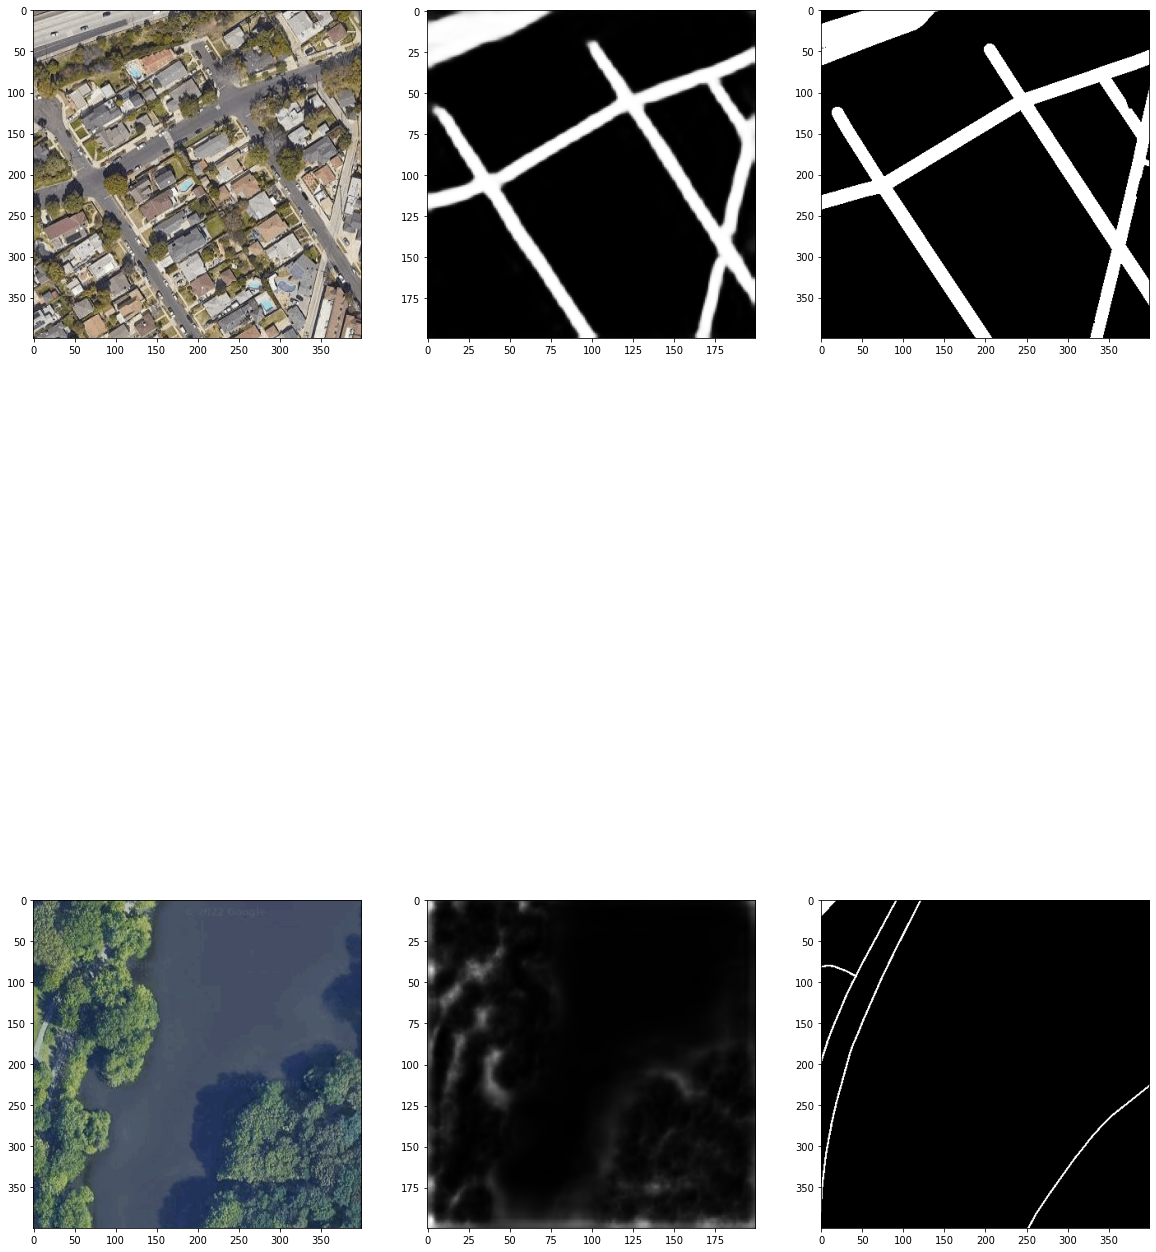

In [19]:
visualize_sample(model, val_loader)

In [ ]:
with torch.no_grad():
    test_path = main_path + "test/images/"    

    files = os.listdir(test_path)
    for file in tqdm(files):
        # print(test_path)
        # print(file)
        x_orig:Image = Image.open(test_path + file).convert("RGB")
        x_orig = np.array(x_orig, dtype=np.float32)/255
        x = feature_extractor(images=x_orig, return_tensors="pt").pixel_values.squeeze(0).cuda()
        pred = model(x.unsqueeze(0)).logits
        pred = torch.repeat_interleave(torch.repeat_interleave(pred, 2, dim=2), 2, dim=3)
        pred = pred.squeeze(0)
        pred = torch.sigmoid(pred).permute(1, 2, 0).cpu().numpy()
        # print(pred.shape) # (400, 400, 1)
        pred = pred.squeeze(-1)
        # print(pred.shape) # (400, 400)
        pred = Image.fromarray((pred*255).astype(np.uint8))

        output_dir = "/kaggle/working/pred/"
        #make the folder
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        pred.save(output_dir + file)


In [ ]:
# zip the folder
import shutil
shutil.make_archive("/kaggle/working/pred", 'zip', output_dir)